In [ ]:
!pip install -q mtcnn 

In [1]:
!pip install -q facenet-pytorch

     |████████████████████████████████| 1.9 MB 5.2 MB/s eta 0:00:01


In [94]:
import tarfile 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt 
import numpy as np 
import os, time, uuid
from glob import glob 
from tqdm import tqdm 
import cv2 
from PIL import Image 
import pickle 
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.metrics.pairwise import cosine_similarity
from statistics import mean 
from typing import Dict, Any, Union 
from mtcnn.mtcnn import MTCNN as MT

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(0)
np.random.seed(0)


cuda:0


In [3]:
%cd ./drive/MyDrive/

/content/drive/MyDrive


In [5]:
with tarfile.open("AFAD-Lite.tar.xz", "r:xz") as f:
    f.extractall("./Github/face")

画像を空間vectorに変換するモデルの転移学習をする

In [4]:
class Transform():
    def __init__(self, resize=160):
        '''推論時の顔を検証した画像それぞれに対して前処理する関数'''
        self.data_trans = {
            "val": transforms.Compose([
                                     transforms.Resize((resize, resize)),
                                     transforms.ToTensor(),
                                     transforms.Lambda(lambda x: x*2-1)  
            ])
        }

    def __call__(self, phase, img):
        return self.data_trans[phase](img) # (3, 160, 160)

class MyDataSet(object):
    def __init__(self):
        self.root_path = "./Github/face/AFAD-Lite/"
        self.trans = Transform()
        self.files = []
        self.sex = []
        self.age = []

        self._load()

    def _load(self):
        for f in glob(self.root_path+"*/"+"*/"+"*.jpg"):
            age = int(f.split("/")[4]) 
            sex = int(f.split("/")[5]) - 111 # {0: male, 1: female}
            self.files.append(f)
            self.age.append(age)
            self.sex.append(sex)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        img = self.trans("val", img) # (c, w, h)
        age = torch.tensor(self.age[idx], dtype=torch.float32)
        sex = torch.tensor(self.sex[idx])
        return img, sex, age

    def __len__(self):
        return len(self.files)

mydata = MyDataSet()


In [5]:
mydata.__getitem__(0)

(tensor([[[-0.9451, -0.9451, -0.9451,  ..., -0.9608, -0.9686, -0.9686],
          [-0.9686, -0.9686, -0.9608,  ..., -0.9686, -0.9686, -0.9608],
          [-0.9765, -0.9765, -0.9608,  ..., -0.9686, -0.9608, -0.9686],
          ...,
          [-0.6627, -0.6784, -0.6863,  ..., -0.7255, -0.7098, -0.7020],
          [-0.6392, -0.6627, -0.6863,  ..., -0.7098, -0.6941, -0.6941],
          [-0.6392, -0.6627, -0.6706,  ..., -0.6863, -0.6784, -0.6863]],
 
         [[-0.9294, -0.9294, -0.9137,  ..., -0.9216, -0.9137, -0.9137],
          [-0.9294, -0.9294, -0.9137,  ..., -0.9216, -0.9137, -0.9059],
          [-0.9216, -0.9216, -0.9137,  ..., -0.9216, -0.9059, -0.9059],
          ...,
          [-0.0039, -0.0118, -0.0196,  ..., -0.0431, -0.0196, -0.0118],
          [ 0.0118, -0.0118, -0.0196,  ..., -0.0275, -0.0118, -0.0196],
          [ 0.0118, -0.0039, -0.0196,  ..., -0.0196, -0.0118, -0.0118]],
 
         [[-0.7490, -0.7490, -0.7569,  ..., -0.7098, -0.7098, -0.7098],
          [-0.7725, -0.7725,

In [6]:
train_dl = torch.utils.data.DataLoader(mydata, batch_size=32,
                                       num_workers=2, shuffle=True, drop_last=True)


In [7]:
# 参照書籍: PytorchではじめるAI開発 6章から一部抜粋
class AsiaFaceNet(nn.Module):
    def __init__(self):
        super(AsiaFaceNet, self).__init__()
        '''
        モデルそのままでは人種による精度低下がみられるのでアジア人種のデータセットで転移学習をする
        なお、損失関数として年齢と性別を設ける。
        '''
        self.base = InceptionResnetV1(pretrained="vggface2")
        # 最終層のみ学習させる
        for name, weight in self.base.named_parameters():
            if name in ["last_linear.weight", "last_bn.weight", "last_bn.bias"]:
                weight.requires_grad = True 
            else:
                weight.requires_grad = False 
        self.age = nn.Linear(512, 1)
        self.sex = nn.Linear(512, 2)

    def forward(self, x):
        y = self.base(x)
        age = F.hardtanh(self.age(y), 15, 75)
        sex = self.sex(y)
        return y, age, sex 

net = AsiaFaceNet()


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [10]:
def train(net, img, age, sex, optimizer, criterion_age, criterion_sex) -> float:
    out, out_age, out_sex = net(img)
    optimizer.zero_grad()
    loss_age = criterion_age(out_age.view(-1), age) # 2乗誤差
    loss_sex = criterion_sex(out_sex, sex) # エントロピーによる分類誤差
    loss = loss_age + loss_sex
    loss.backward()
    optimizer.step()
    return loss.item()

def show_loss(loss):
    plt.figure(figsize=(14, 5))
    plt.plot(np.arange(len(loss)).tolist(), loss)
    plt.title("Train Loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.show()

def save(model, e):
    os.makedirs("models/", exist_ok=True)
    torch.save(net.state_dict(), f"models/facenet{e}.pth")
    print("successfully saving model")

def trainer(train_dl, net, num_epoch=1):
    net.to(device)
    # 学習済モデルを大きく変えたくないので学習係数は小さめで設定かつエポック数は１
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-5)
    criterion_age = torch.nn.L1Loss()
    criterion_sex = torch.nn.CrossEntropyLoss()
    plot_loss = []
    start = time.time()

    for e in range(num_epoch):
        losses = []
        net.train()
        for i, (img, sex, age) in enumerate(tqdm(train_dl)):
            img = img.to(device)
            sex = sex.to(device)
            age = age.to(device)

            loss = train(net, img, age, sex, optimizer, criterion_age, criterion_sex)
            losses.append(loss)
            # 学習エポック数は１なのでイテレーションを基準として損失値の可視化をする
            if i%100 == 0:
                plot_loss.append(mean(losses))
                losses = []
    print(f"{e+1}/{num_epoch} | train | loss: {mean(plot_loss)}")
    try:
        show_loss(plot_loss, num_epoch) 
        save(net, num_epoch)
    finally:   
        now = time.time()
        print(f"elapsed time {now-start:.5f}s")
        # 不要になった計算フラフをgpuの削除
        del loss 
        if device:
            torch.cuda.empty_cache()
        return net 
            

In [11]:
trained_net = trainer(train_dl, net)

100%|██████████| 1067/1067 [1:02:16<00:00,  3.50s/it]

1/1 | train | loss: 11.526771183013915
elapsed time 3736.14849s


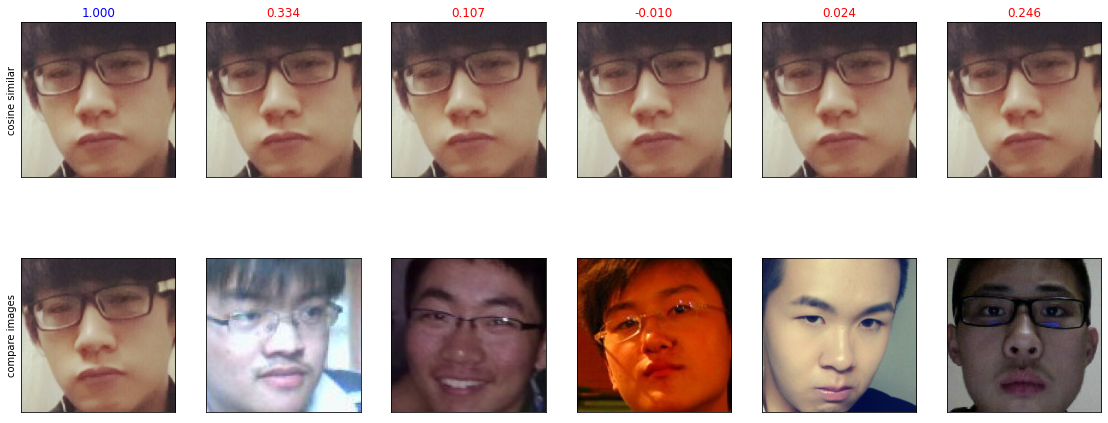

In [148]:
def load_net():
    '''
    モデルの読み込み
    '''
    net = AsiaFaceNet()
    net.load_state_dict(torch.load("./Github/face/models/facenet1.pth", map_location={"cuda:0": "cpu"}))
    net.eval()
    mtcnn = MT() # 複数人を同時検知
    mtcnn_for_facenet = MTCNN() # 単独で検知
    return net, mtcnn_for_facenet, mtcnn # No GPU

def evaluate(idx=0, is_sex=1):
    '''
    訓練データからランダムに６人選択してそれぞれ埋め込み空間を出力し類似度を算出する
    '''
    with torch.no_grad():
        net, _, _  = load_net()
        trans = Transform()
        is_sex = int(is_sex)
        random_img = glob(f"./Github/face/AFAD-Lite/18/11{is_sex}/*.jpg")
        result = []
        for f in random_img[idx:idx+6]:
            img = Image.open(f).convert("RGB")
            img = trans("val", img).unsqueeze(0)
            out, _, _, = net(img)
            out = out[0].detach().cpu().numpy()
            result.append(out)

        fig, axes = plt.subplots(2, 6, figsize=(15, 6))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        ax = axes.ravel()
        for i in range(1):
            img1 = Image.open(random_img[idx]).convert("RGB")
            for ii, compare in enumerate(random_img[idx:idx+6]):
                img2 = Image.open(compare).convert("RGB")
                sim = cosine_similarity(result[0].reshape(1, -1), result[ii].reshape(1, -1))
                ax[ii].imshow(img1)
                ax[ii].set_title(f"{sim[0][0]:.3f}", color="b" if sim[0][0] > 0.5 else "r")
                ax[ii].set_xticks([])
                ax[ii].set_yticks([])
                ax[ii+6].imshow(img2)
                ax[ii+6].set_xticks([])
                ax[ii+6].set_yticks([])
                if ii == 0:
                    ax[ii].set_ylabel("cosine similar")
                    ax[ii+6].set_ylabel("compare images")
        os.makedirs("./Github/face/img", exist_ok=True)
        fig.savefig("./Github/face/img/sim_face.png")

evaluate() # 男性


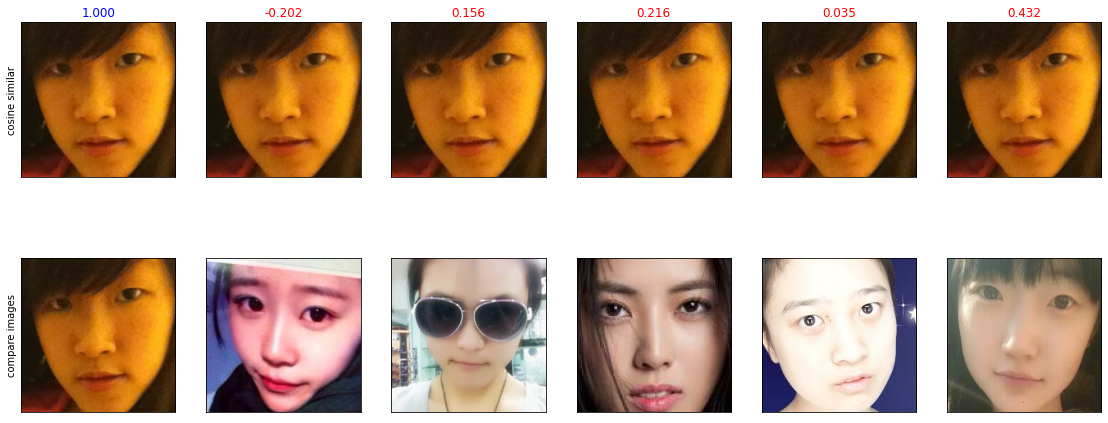

In [56]:
evaluate(13, 2) # 女性

推論関数の作成
---  
  
1. ユーザーが自身の顔を空間ベクトルとして保存
2. 本人を含んだ複数人が移る画像から顔を検知
3. 検知した分だけ空間ベクトルに変換し、登録されているベクトルとの類似度を算出
4. 評価を矩形で囲み画像ファイルとして保存する

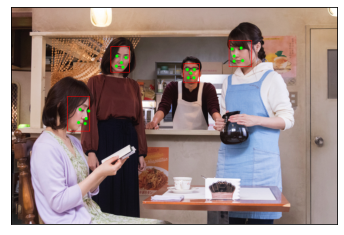

In [202]:
# 参照:https://betashort-lab.com/%e7%94%bb%e5%83%8f%e5%87%a6%e7%90%86/opencv%e3%81%a7%e9%a1%94%e6%a4%9c%e5%87%ba%e3%81%a8%e6%8a%bd%e5%87%ba/#toc3
# cas_file = "./Github/face/kasumi/haarcascade_frontalface_alt.xml"
# cas = cv2.CascadeClassifier(cas_file)
sample_path = "./Github/face/kasumi/kasumi2.jpg"
sample_img = cv2.imread(sample_path)
# face_list = cas.detectMultiScale(img_gray)

# cv2による顔検出では精度があまり良くなかったので別モデルを使用
# 参照:https://qiita.com/usk81/items/9c9111a8db298eaa7ba9
img_ = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
mtcnn = MT()
face_list = mtcnn.detect_faces(img_)

if len(face_list) == 0:
    print("no detections")
    quit()
for face in face_list: # 人数文だけ座標を出力してくれる
    x = face["box"][0]
    y = face["box"][1]
    w = face["box"][2]
    h = face["box"][3]
    key = face["keypoints"]
    cv2.rectangle(sample_img, (x, y), (x+w, y+h), (0, 0, 255), thickness=1)
    cv2.circle(sample_img, key["mouth_left"], 3, (0, 255, 0), thickness=-1)
    cv2.circle(sample_img, key["mouth_right"], 3, (0, 255, 0), thickness=-1)
    cv2.circle(sample_img, key["nose"], 3, (0, 255, 0), thickness=-1)
    cv2.circle(sample_img, key["right_eye"], 3, (0, 255, 0), thickness=-1)
    cv2.circle(sample_img, key["left_eye"], 3, (0, 255, 0), thickness=-1)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

In [173]:
def detect(img: torch.Tensor, net) -> np.ndarray:
    '''
    入力は前処理済の顔画像
    shape (b, c, w, h)
    '''
    with torch.no_grad():
        out, _ , _ = net(img) # 推論時には性別、年齢の予測は使わない
        out = out[0].detach().cpu().numpy() # (512, )
    return out 

def register(img_path: str):
    '''
    画像からベクトル変換し、リストに登録する関数
    前提としてfacenet_pytorch.MTCNNでは複数人を同時に検知しないので、単独の顔写真を読み込む
    '''
    regist_path = "./Github/face/data/"
    net, mtcnn, _  = load_net()
    img = Image.open(img_path).convert("RGB")
    face = mtcnn(img).unsqueeze(0) # 自動的にfacenetの入力形式に変換される (b, c, w, h)
    out = detect(face, net)
    # ベクトルをデータとして登録する
    with open(regist_path+"register.pkl", "wb") as f:
        pickle.dump([out], f)
    print("登録が完了しました。")

def discrimination(img_path: str, threshold=0.40) -> Dict[str, float]:
    '''
    複数人が移っている画像から登録されている画像と同人物を検知して写真として返す
    '''
    with open("./Github/face/data/register.pkl", "rb") as f:
        register_v = pickle.load(f) # (1, 512)
    # 複数人を同時に検知したいのでMTCNNを用いる
    # こちらは自動でテンソルに変換しないので自身の前処理クラスで形状を整える
    net, _, mtcnn = load_net()
    trans = Transform()
    # 描画オブジェクトの生成
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    id = uuid.uuid4()

    # cas_file = "./Github/face/kasumi/haarcascade_frontalface_alt.xml"
    # cas = cv2.CascadeClassifier(cas_file)
    sample_img = cv2.imread(img_path)
    imgs = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    # face_list = cas.detectMultiScale(img_gray)
    face_list = mtcnn.detect_faces(imgs)
    results = {"id": "detected_"+str(id)[:2]}
    for i, faces in enumerate(face_list): # 検知された顔画像の分だけループする
        # 座標の取得
        x = faces["box"][0]
        y = faces["box"][1]
        w = faces["box"][2]
        h = faces["box"][3]
        # 顔領域の切り出し
        face = cv2.cvtColor(sample_img[y:y+h, x:x+w], cv2.COLOR_BGR2RGB) # (w, h, c)
        # 前処理
        face = Image.fromarray(face)
        face_tensor = trans("val", face).unsqueeze(0)
        # 推論によるvector化
        out = detect(face_tensor, net).reshape(1, -1)
        # 類似度
        sim = cosine_similarity(register_v, out)[0][0]
        color = (0, 255, 0) if sim >= threshold else (0, 0, 255)
        # 判定を基に矩形で囲む
        cv2.rectangle(sample_img, (x, y), (x+w, y+h), color, thickness=2)
        cv2.putText(sample_img, text=str(i), org=(x, y), color=color, thickness=1, 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.0)
        # アノテーションの作成
        result = {
            "face": [x, y, w, h],
            "discrimination": 1 if sim >= threshold else 0, 
            "similar": sim
        }
        results[f"{str(i)}"] = result
    plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    fig.savefig(f"./Github/face/img/detected_{str(id)[:2]}.png")
    return results 

In [161]:
register("./Github/face/kasumi/kasumi1.jpg")

登録が完了しました。


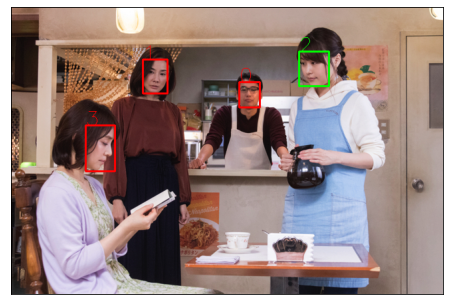

{'0': {'discrimination': 0, 'face': [343, 114, 31, 38], 'similar': 0.14793287},
 '1': {'discrimination': 0, 'face': [198, 80, 37, 51], 'similar': 0.027136333},
 '2': {'discrimination': 1, 'face': [433, 68, 45, 52], 'similar': 0.4844016},
 '3': {'discrimination': 0, 'face': [112, 179, 44, 69], 'similar': 0.3260647},
 'id': 'detected_50'}

In [188]:
discrimination("./Github/face/kasumi/kasumi2.jpg")

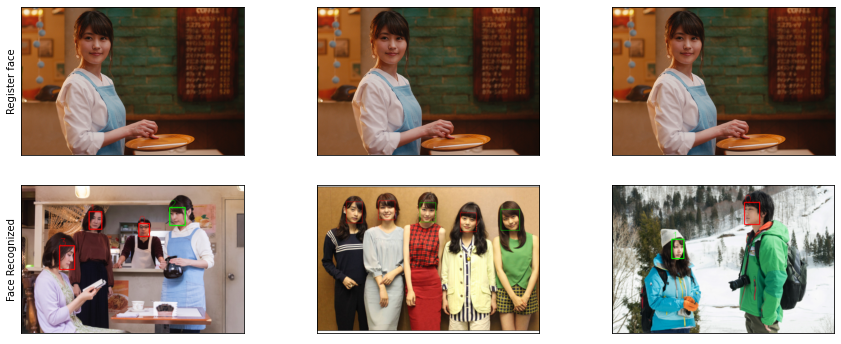

In [194]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
ax = axes.ravel()
img1 = "./Github/face/kasumi/kasumi1.jpg"
img2 = "./Github/face/img/detected_de.png"
img3 = "./Github/face/img/detected_c7.png"
img4 = "./Github/face/img/detected_ad.png"
img1 = Image.open(img1)
img2 = Image.open(img2)
img3 = Image.open(img3)
img4 = Image.open(img4)

ax[0].imshow(img1)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(img1)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(img1)
ax[2].set_xticks([])
ax[2].set_yticks([])

ax[3].imshow(img4)
ax[3].set_xticks([])
ax[3].set_yticks([])

ax[4].imshow(img2)
ax[4].set_xticks([])
ax[4].set_yticks([])

ax[5].imshow(img3)
ax[5].set_xticks([])
ax[5].set_yticks([])

ax[0].set_ylabel("Register face")
ax[3].set_ylabel("Face Recognized")

plt.show()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig.savefig("./Github/face/img/recognized.png")
# 上の画像と同じ人物と予測されれば緑、別人物であれば赤の矩形で囲む
# ただし、ここでは検証結果を可視したかったので閾値を小さめで設定。
# 結果として男女間では識別できているが、同性になると誤検知が増えている。